In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import process_data
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
# SE3 pricing 

In [4]:
data_raw = process_data.get_data()

In [5]:
split_date = '12-march-2024'
data_train = data_raw.loc[data_raw.index <= split_date].copy()
data_test = data_raw.loc[data_raw.index > split_date].copy()

# Plot train and test so you can see where we have split
data_test \
    .rename(columns={'Energy_Wh': 'TEST SET'}) \
    .join(data_train.rename(columns={'Energy_Wh': 'TRAINING SET'}),
          how='outer')
    


,TEST SET,TRAINING SET
Start time,,
2024-01-01 00:00:00,NaN,1.679920e+05
2024-01-01 08:00:00,NaN,3.186965e+05
2024-01-01 09:00:00,NaN,5.032050e+04
2024-01-01 12:00:00,NaN,5.129432e+05
2024-01-01 13:00:00,NaN,1.210330e+06
...,...,...
2024-10-02 11:00:00,2.863899e+05,NaN
2024-10-02 12:00:00,8.099801e+05,NaN
2024-10-02 13:00:00,9.281629e+05,NaN


00:24:24 - cmdstanpy - INFO - Chain [1] start processing
00:24:24 - cmdstanpy - INFO - Chain [1] done processing


                 ds_x              y                date                ds_y  \
0 2024-03-13 07:00:00   76489.448276 2024-03-13 07:00:00 2024-03-13 07:00:00   
1 2024-03-13 08:00:00   53992.551724 2024-03-13 08:00:00 2024-03-13 08:00:00   
2 2024-03-13 09:00:00   46693.705882 2024-03-13 09:00:00 2024-03-13 09:00:00   
3 2024-03-13 10:00:00  668391.731618 2024-03-13 10:00:00 2024-03-13 10:00:00   
4 2024-03-13 11:00:00  624789.024038 2024-03-13 11:00:00 2024-03-13 11:00:00   

   pred_price_index        revenue  day  
0          1.021293   78118.114573   13  
1          1.032600   55752.700561   13  
2          1.049827   49020.300329   13  
3          1.075886  719113.492138   13  
4          1.108455  692550.683722   13  
day
1     0.000000e+00
2     0.000000e+00
3     0.000000e+00
4     0.000000e+00
5     0.000000e+00
6     0.000000e+00
7     0.000000e+00
8     0.000000e+00
9     0.000000e+00
10    0.000000e+00
11    0.000000e+00
12    0.000000e+00
13    3.900880e+06
14    4.207670e+

(np.float64(19793.0), np.float64(19796.0))

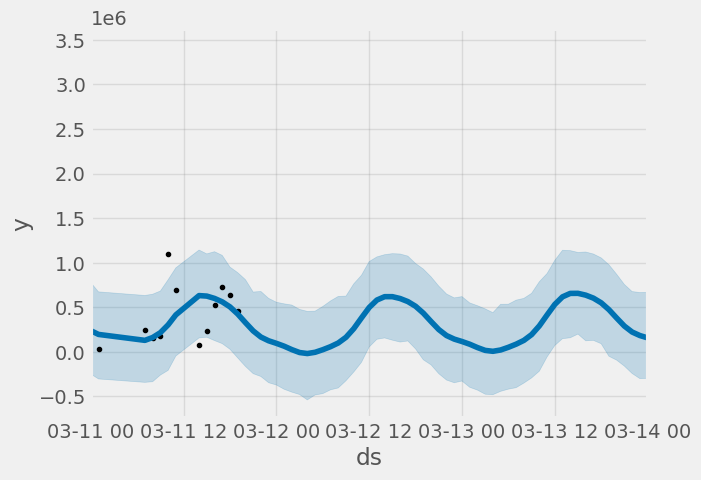

In [ ]:
data_train_prophet = data_train.reset_index().rename(columns={'Start time':'ds','Energy_Wh':'y'})

data_test_prophet = data_test.reset_index().rename(columns={'Start time':'ds','Energy_Wh':'y'})
m = Prophet(changepoint_prior_scale=1, seasonality_mode='multiplicative').fit(data_train_prophet)
future = m.make_future_dataframe(periods=72, freq='H')
fcst = m.predict(future)
fig, ax1 = plt.subplots()
# ax1.plot(fcst['ds'], fcst['yhat'], label='Forecasted Values')
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Predicted', color='blue')


fig = m.plot(fcst, ax=ax1)
# fig = m.plot_components(fcst)
price_per_wh = 4.56 / 1000

predicted_day = fcst[fcst['ds'].dt.day == 13]

def scale_value(y, ymin=predicted_day['yhat'].min(), ymax=predicted_day['yhat'].max(), scalemin=1, scalemax=1.2):
    return (y - ymin) / (ymax - ymin) * (scalemax - scalemin) + scalemin

# tabell vid varje timme och prisindex
last_date = '13-march-2024'
# TODO use min of day for ymin and max of day for ymax
fcst['pred_price_index'] = fcst['yhat'].apply(lambda yhat: scale_value(yhat))
columns_to_keep = ['pred_price_index', 'ds']
price_index_by_hour = fcst.drop(columns=[col for col in fcst.columns if col not in columns_to_keep])
price_index_by_hour['date'] = pd.to_datetime(price_index_by_hour['ds'])
price_index_by_hour = price_index_by_hour[price_index_by_hour['date'] > '2024-03-13']


data_test_prophet['date'] = pd.to_datetime(data_test_prophet['ds'])
data_last_day = data_test_prophet[data_test_prophet['date'] > '2024-03-13']

data_last_day = pd.merge(data_last_day, price_index_by_hour, on='date', how='left')
data_last_day['revenue'] = data_last_day['y'] * data_last_day['pred_price_index']
data_last_day['day'] = data_last_day['date'].dt.day
# TODO fix revenue 0 below...
print(data_last_day.head())
revenue_last_day = data_last_day.groupby('day')['revenue'].sum()
print(revenue_last_day)

# data_last_day.set_index('date', inplace=True)
# price_index_by_hour.set_index('date', inplace=True)

# if data_last_day.index.equals(price_index_by_hour.index):
#     # Step 2: Merge the DataFrames using an outer join
#     merged_df = pd.merge(data_last_day, price_index_by_hour, on='date', how='outer')

#     # Step 3: Perform element-wise multiplication
#     result = merged_df['y'] * merged_df['pred_price_index']

#     print(result)
# else:
#     print("The indices of the two DataFrames do not match.")
# data_last_day_grouped = data_last_day.groupby('day').aggregate({"y": 'sum'})
# total_earnings_last_day = data_last_day_grouped['y'] 
# print(total_earnings_last_day)





# fcst['day'] = fcst['ds'].dt.day
# predicted_last_day = fcst[fcst['day'] == 13]
# columns_to_keep = ['day', 'pred_price_index', 'ds']
# predicted_last_day = predicted_last_day.drop(columns=[col for col in predicted_last_day.columns if col not in columns_to_keep])
# predicted_last_day['pred_earnings'] = predicted_last_day['pred_price_index'] * predicted_last_day['yhat']
# data_last_day_grouped = predicted_last_day.groupby('day').aggregate({'pred_earnings': 'sum'})
# print(data_last_day_grouped)
# fcst['pred_earnings'] = fcst['pred_price_index'] * price_per_wh
# fcst['day'] = fcst['ds'].dt.day
# predicted_earnings_last_day = fcst[fcst['day'] == 13].groupby('day').aggregate({'pred_earnings': 'sum'})
# print(predicted_earnings_last_day)

# ax2 = ax1.twinx()
# ax2.plot(fcst['ds'], fcst['pred_price_index'], color='green')
# ax2.set_ylabel('Pct cost')

plt.xlim(datetime(2024,3,11),datetime(2024,3,14))
# print(fcst.head())

In [ ]:
# actual earning per day
